In [1]:
import numpy as np
from keras.datasets import mnist

In [2]:
(x_train, y_train), (x_test, y_test) = mnist.load_data()

11490434/11490434 [==============================] - 0s 0us/step


In [4]:
# 2d (28, 28) --> 1d (768)

In [5]:
RESHAPE = 784
x_train_flat = x_train.reshape([60000, RESHAPE])
x_test_flat = x_test.reshape([x_test.shape[0], RESHAPE])
x_train_flat.shape, x_test_flat.shape

((60000, 784), (10000, 784))

In [6]:
#0~255 --> 0~1 
x_train_flat = x_train_flat/255.0
x_test_flat = x_test_flat/255.0

In [ ]:
# 5 --> [0, 0, 0, 0, 1, 0, 0, 0, 0, 0]  #one hot encoding
# y_train_encoding = np.eye(10)[y_train]
# y_test_encoding = np.eye(10)[y_test]

In [9]:
y_train_encoding = y_train.reshape([-1, 1])
y_test_encoding = y_test.reshape([-1, 1])

In [10]:
x_train_flat.shape, y_train_encoding.shape, x_test_flat.shape, y_test_encoding.shape

((60000, 784), (60000, 1), (10000, 784), (10000, 1))

In [11]:
# batch 
batch_size = 100

In [12]:
batch_x_train = x_train_flat.reshape([-1, batch_size, x_train_flat.shape[1] ])
batch_x_test = x_test_flat.reshape([-1, batch_size, x_test_flat.shape[1] ])

In [13]:
batch_y_train = y_train_encoding.reshape([-1, batch_size, y_train_encoding.shape[1]])
batch_y_test = y_test_encoding.reshape([-1, batch_size, y_test_encoding.shape[1]])

In [14]:
batch_x_train.shape, batch_y_train.shape, batch_x_test.shape, batch_y_test.shape

((600, 100, 784), (600, 100, 1), (100, 100, 784), (100, 100, 1))

In [15]:
# model mlp 

In [16]:
import torch
import torch.nn as nn
import torch.nn.functional as F

In [17]:
class MultilayerPerceptron(nn.Module):
  def __init__(self, in_sz , out_sz, layers=[120, 84]):
    super().__init__()
    #network shape 
    self.fc1 = nn.Linear(in_sz,layers[0])
    self.fc2 = nn.Linear(layers[0],layers[1])
    self.fc3 = nn.Linear(layers[1],out_sz)

  def forward(self, X):
    X = F.relu(self.fc1(X))
    X = F.relu(self.fc2(X))
    X = self.fc3(X)

    return X

In [18]:
batch_x_train.shape[2], batch_y_train.shape[2]

(784, 1)

In [19]:
model = MultilayerPerceptron(batch_x_train.shape[2], batch_y_train.shape[2])

In [20]:
import torchsummary

In [21]:
torchsummary.summary(model, (1, 784), device='cpu') # summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1               [-1, 1, 120]          94,200
            Linear-2                [-1, 1, 84]          10,164
            Linear-3                 [-1, 1, 1]              85
Total params: 104,449
Trainable params: 104,449
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.00
Params size (MB): 0.40
Estimated Total Size (MB): 0.40
----------------------------------------------------------------


In [22]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [23]:
# model to gpu
model = model.to(device)

In [24]:
# data np --> tensor
batch_x_train_t = torch.Tensor(batch_x_train)
batch_y_train_t = torch.Tensor(batch_y_train)
batch_x_test_t  = torch.Tensor(batch_x_test)
batch_y_test_t  = torch.Tensor(batch_y_test)

In [25]:
batch_x_train_t.shape

torch.Size([600, 100, 784])

# hyper parameter , (optimizer, loss)

In [26]:
# criterion =  nn.CrossEntropyLoss()  # LOSS #개 0 고양이 1 # MSE : 주가, 체중, 기상 온도, # 0, 1, 3, 4, 
criterion =  nn.MSELoss()  

In [27]:
learning_rate = 1e-2 # 0.01
optim = torch.optim.Adam(model.parameters(), lr = learning_rate)

In [28]:
epochs = 10 # 60000 * 10

In [31]:
for it_epochs in range(epochs):
  #train_corr =0 # 매번 Epoch 마다 정확도 변화를 확인하기위한 변수
  train_loss = 0
  test_corr =0 # 
  model.train() # 기울기를 저장함 --> molde.eval() evaluate() 기울기를 저장하지않음
  for it_batch in range(batch_x_train_t.shape[0]):
    # train code
    # in/out data to cuda
    input = batch_x_train_t[it_batch].to(device) # shape [100, 784]
    output = batch_y_train_t[it_batch].to(device) # shape [100, 10]
    # print('train batch ', it_batch)
    #forward 모델 순전파 값 
    pred = model(input) 
    # 역전파, 기울기 업데이트
    # 전에 저장된 기울기 초기화
    optim.zero_grad()
    # 예측값과 정답의 손실 구하기 --> 역전파
    loss = criterion(pred, output)
    train_loss += loss.item()
    loss.backward()
    
    #기울기 반영
    optim.step()
    # metric 정확도 --> 모델이 원하는 방향으로 진행되고 있는지 확인
    # 기울기 계산 하지 않는부분

  with torch.no_grad():
    model.eval()
    for it_test_batch in range(batch_x_test_t.shape[0]):
      in_test = batch_x_test_t[it_test_batch].to(device)
      out_test = batch_y_test_t[it_test_batch].to(device)
      #model inference 
      pred_test = model(in_test) 
      
      # onehot --> [0.2, 0.1, 0.3, ...  ]
      # [100, 10] --> [100, 1]
      # t1 = torch.argmax(pred_test, dim=1)
      # t2 = torch.argmax(out_test, dim=1)
      # 3.4 --> 3 // 4.6 --> 5
      test_corr += torch.sum(torch.round(pred_test) == torch.round(out_test))

      # test_corr += (t1 == t2).sum()
      model.train()
    total_cnt = batch_x_test_t.shape[0]*batch_size
    prt = 'epochs[%d] loss[%.2f] total[%d], acc[%.2f]' % (it_epochs, train_loss/batch_x_train_t.shape[0], total_cnt, test_corr/total_cnt)
    print(prt)
  



epochs[0] loss[0.28] total[10000], acc[0.83]
epochs[1] loss[0.27] total[10000], acc[0.77]
epochs[2] loss[0.26] total[10000], acc[0.78]
epochs[3] loss[0.25] total[10000], acc[0.83]
epochs[4] loss[0.24] total[10000], acc[0.81]
epochs[5] loss[0.24] total[10000], acc[0.84]
epochs[6] loss[0.24] total[10000], acc[0.84]
epochs[7] loss[0.21] total[10000], acc[0.82]
epochs[8] loss[0.22] total[10000], acc[0.84]
epochs[9] loss[0.21] total[10000], acc[0.79]


In [52]:
import matplotlib.pyplot as plt

with torch.no_grad():
  model.eval()
  #data to cuda 
  in_test = batch_x_test_t[0].to(device)
  out_test = batch_y_test_t[0].to(device)
  pred_test = model(in_test)



In [53]:
in_test = in_test.cpu()
out_test = out_test.cpu()

In [54]:
pred_test = pred_test.cpu()

In [55]:
in_test.shape, out_test.shape, pred_test.shape

(torch.Size([100, 784]), torch.Size([100, 1]), torch.Size([100, 1]))

In [50]:
def draw_model_result(img_sample, gt_sample, pred_sample):
  title_ = 'gt[%d], pred[%d]' % (np.round(gt_sample), np.round(pred_sample))
  plt.title(title_)
  plt.imshow(img_sample.reshape([28, 28]), 'gray')
  plt.show()

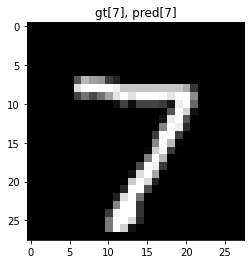

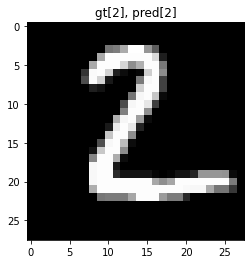

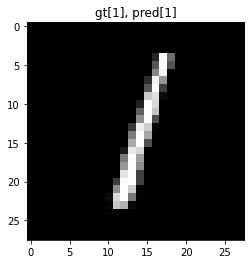

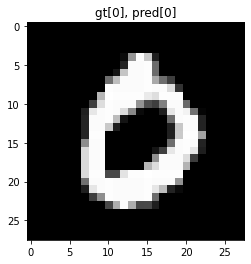

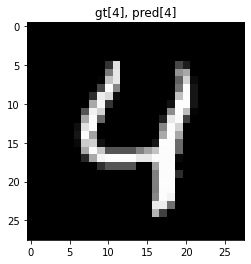

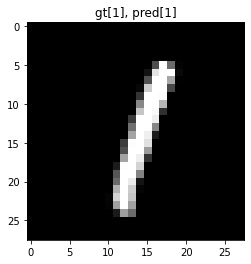

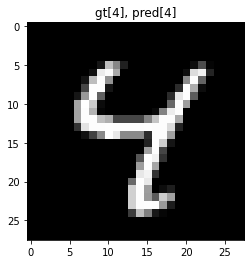

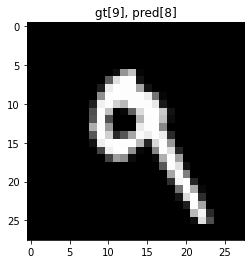

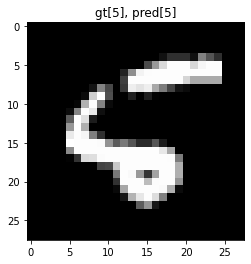

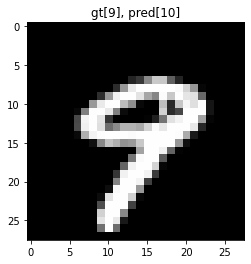

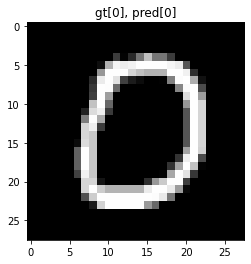

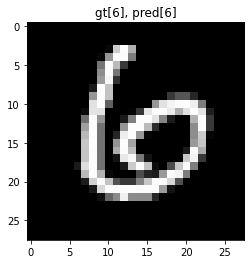

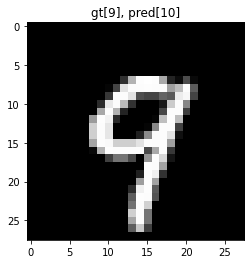

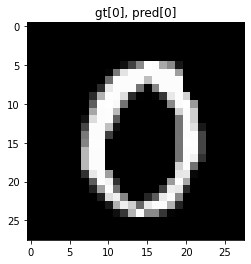

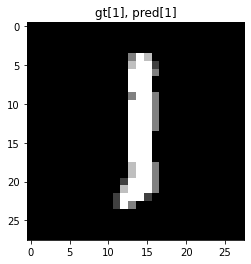

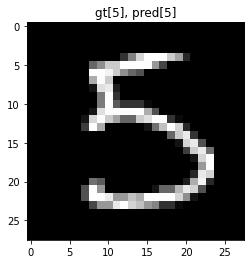

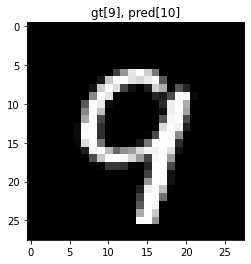

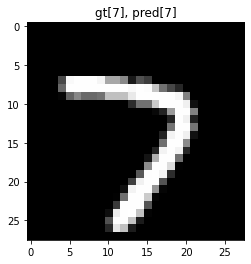

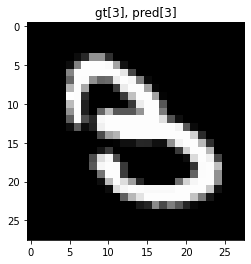

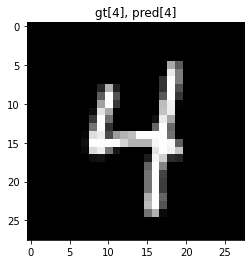

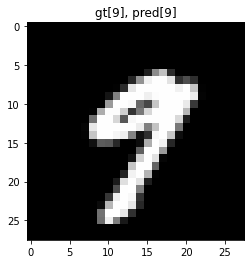

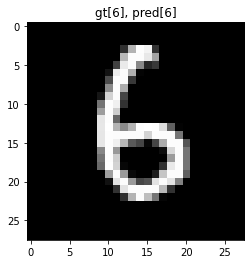

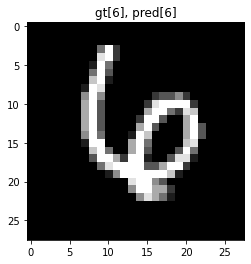

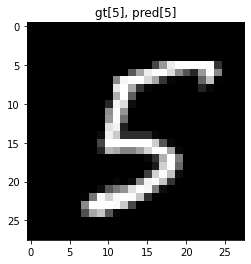

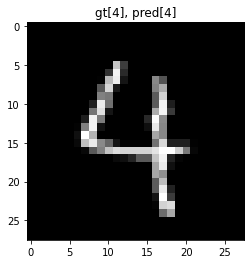

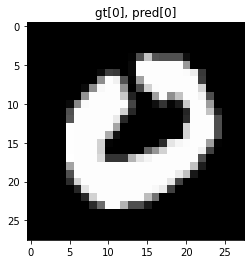

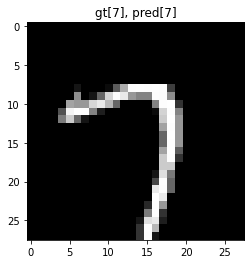

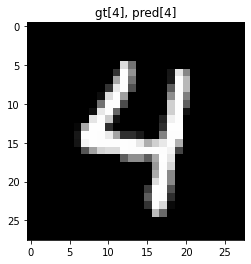

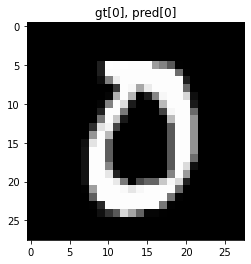

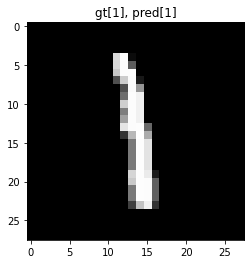

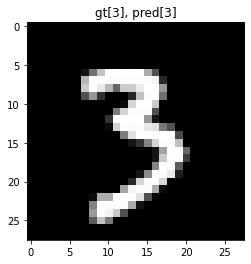

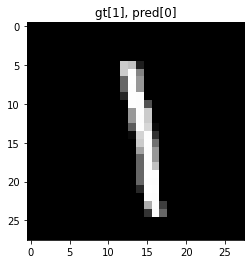

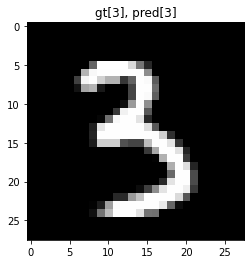

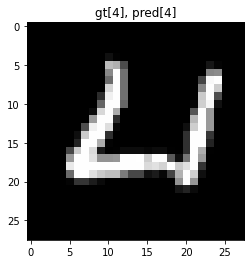

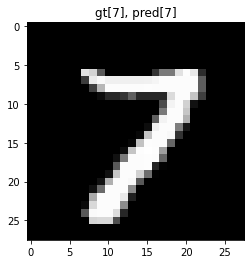

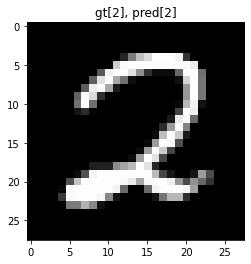

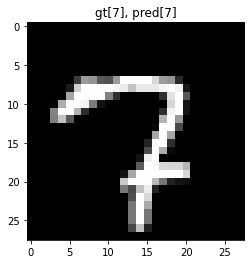

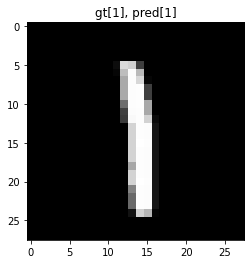

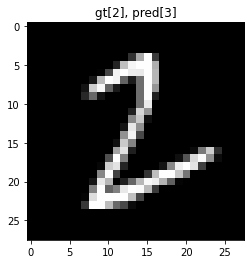

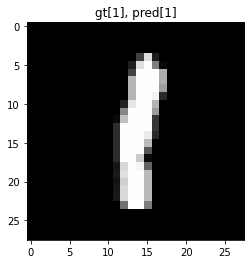

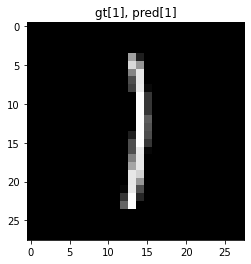

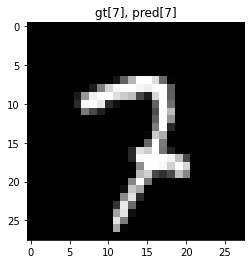

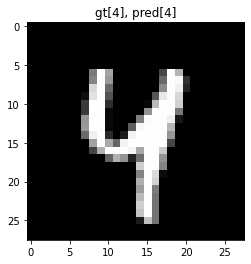

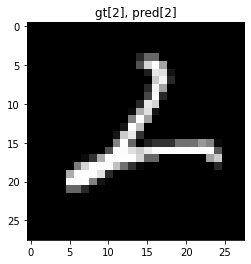

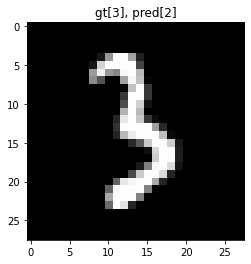

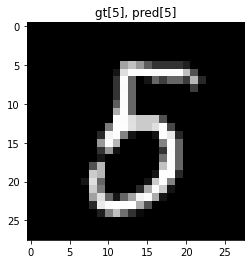

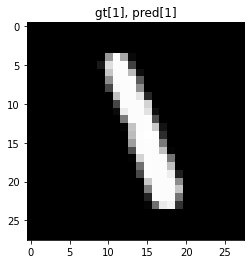

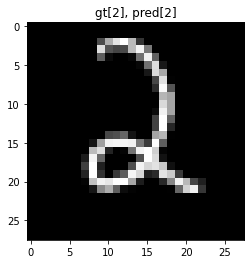

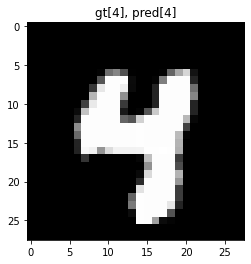

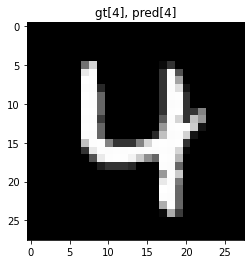

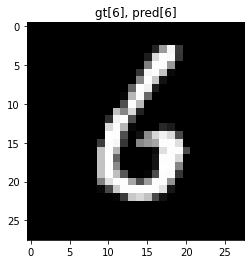

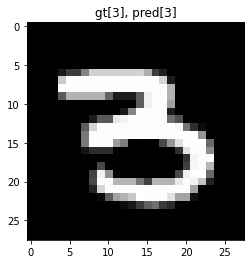

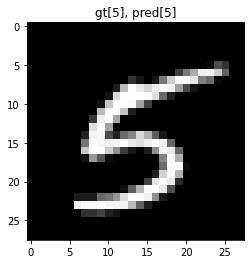

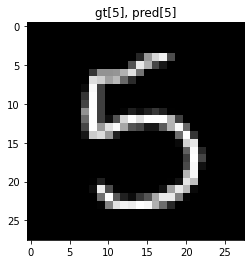

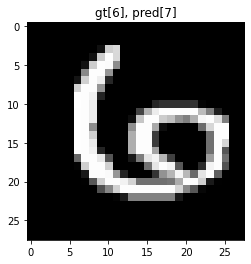

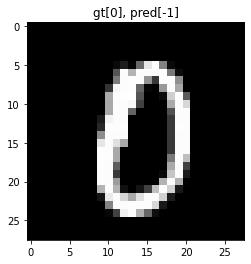

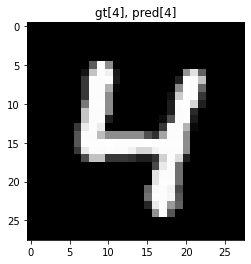

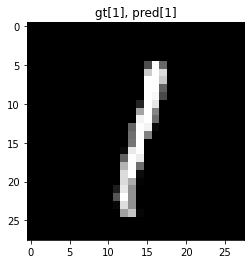

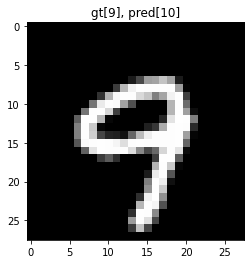

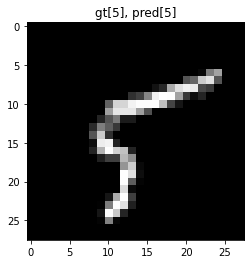

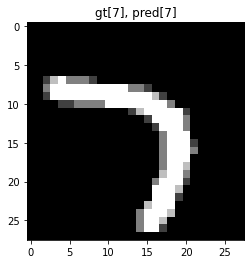

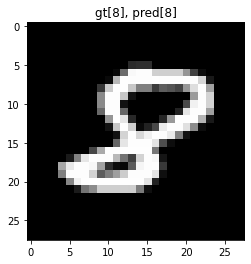

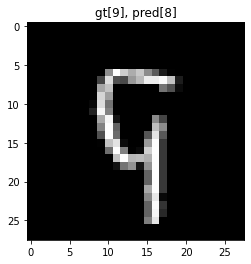

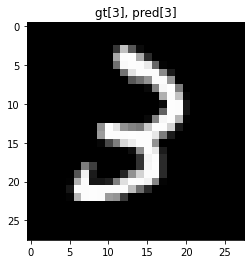

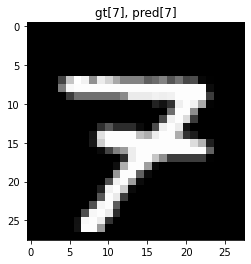

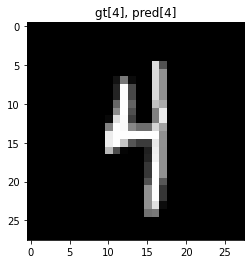

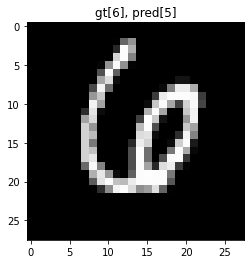

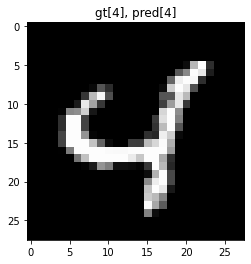

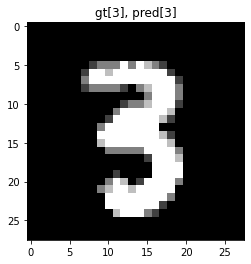

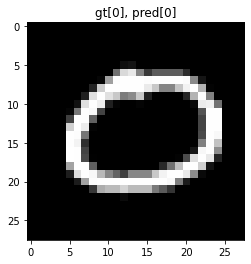

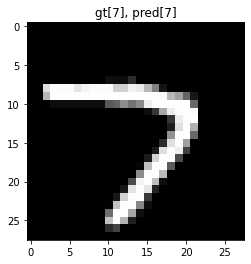

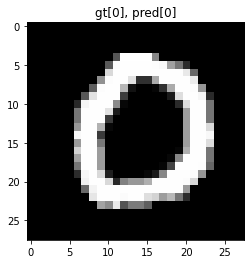

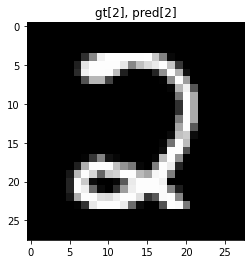

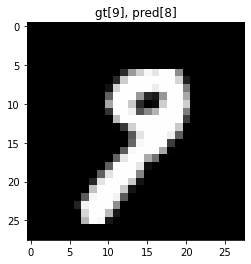

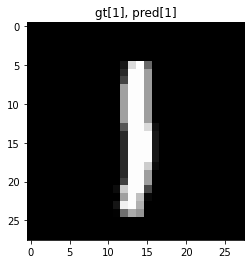

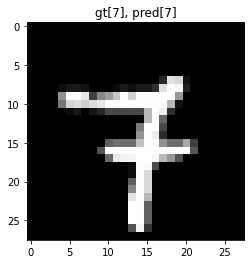

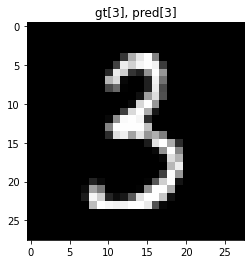

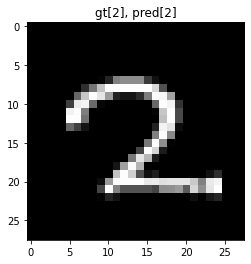

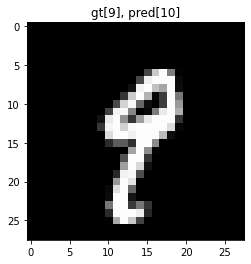

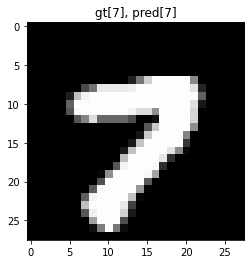

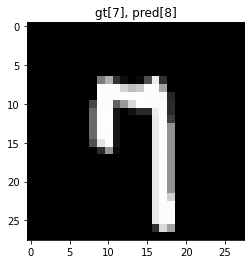

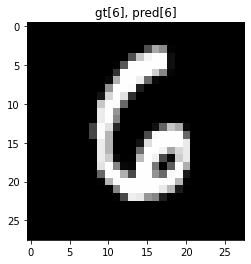

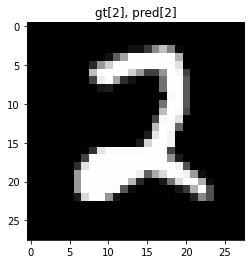

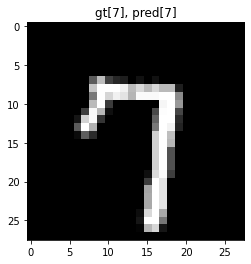

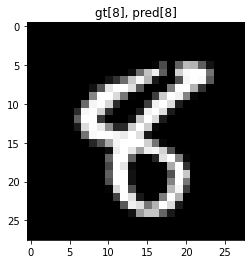

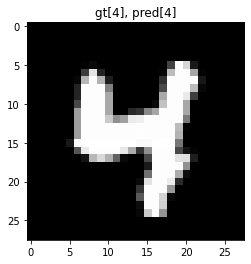

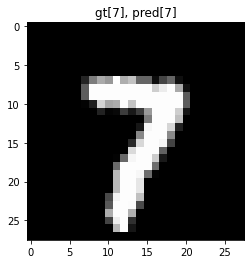

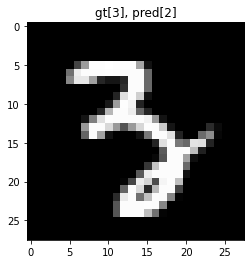

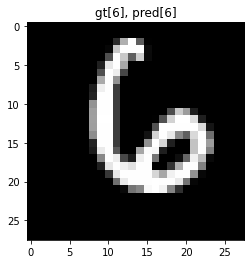

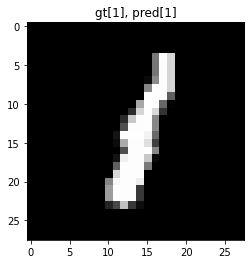

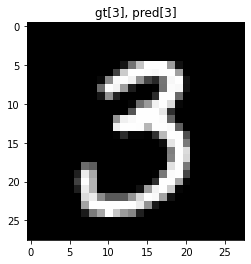

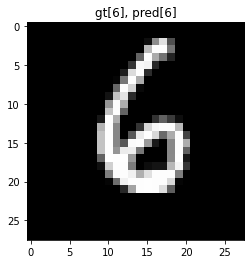

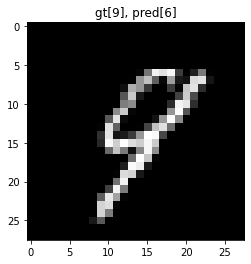

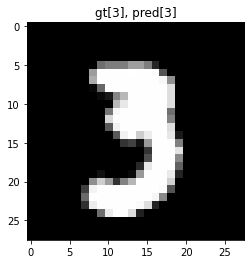

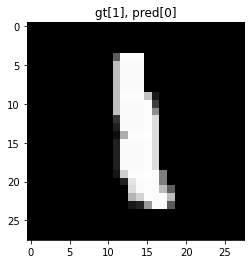

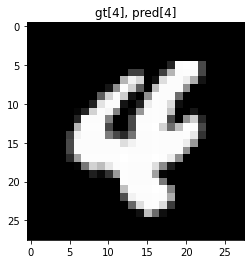

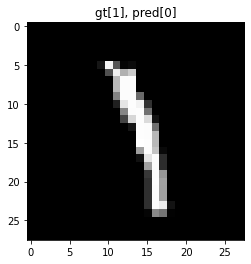

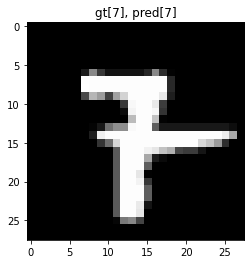

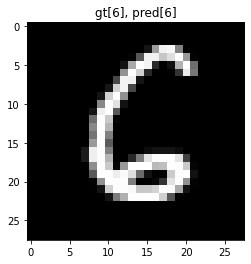

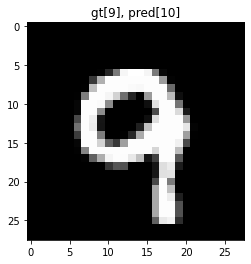

In [59]:
for it_sample in range(in_test.shape[0]):
  draw_model_result(in_test[it_sample].numpy(), out_test[it_sample].numpy(), pred_test[it_sample].numpy())